In [10]:
import numpy as np
import matplotlib.pyplot as plt
import rps.robotarium as robotarium
from rps.utilities.transformations import create_si_to_uni_mapping
from rps.utilities.barrier_certificates import create_single_integrator_barrier_certificate
from rps.utilities.controllers import create_si_position_controller
from matplotlib.patches import Circle
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Parameters
N = 5  # Number of robots
iterations = 4000  # Simulation iterations
sensing_radius = 0.2  # Sensing radius for obstacle avoidance
max_velocity = 0.1  # Maximum velocity to avoid actuator limit errors
fire_radius = 0.21  # Radius of the fire zone
fire_reduction_rate = 0.001  # Rate at which fire is reduced
fire_threshold = 0.01  # Threshold to consider fire extinguished
k_att = 1.0  # Attractive potential scaling factor
k_rep = 0.3  # Repulsive potential scaling factor
random_seed = 42  # Set a random seed for reproducibility

# Set random seed for reproducibility
np.random.seed(random_seed)

# Random obstacles (trees)
num_trees = 3  # Number of random obstacles
tree_positions = np.random.uniform(0.4, -0.4, (2, num_trees))  # Random positions for trees

# Initialize robots at random positions within a bounded region
x_min, x_max = -1, 1  # Bounds for x-coordinate
y_min, y_max = -1, 1  # Bounds for y-coordinate

# Generate random positions for robots
initial_positions_x = np.random.uniform(x_min, x_max, size=N)  # Random x-coordinates
initial_positions_y = np.random.uniform(y_min, y_max, size=N)  # Random y-coordinates
initial_positions = np.vstack((initial_positions_x, initial_positions_y))  # Combine x and y


# Predefined fire locations
fires = [np.array([[-0.8], [0.5]]),  # Fire 1
         np.array([[0.0], [-0.5]]),  # Fire 2
         np.array([[0.5], [0.5]])]   # Fire 3

fire_status = [1.0, 1.0, 1.0]  # Fire intensity (1.0 = full intensity)


# Function to compute attractive potential gradient
def attractive_force(position, goal):
    return -k_att * (position - goal)

# Function to compute repulsive potential gradient, including fire zones and trees
def repulsive_force(position, obstacles, fire_zones, sensing_radius):
    force = np.zeros_like(position)
    for obstacle in obstacles.T:
        diff = position - obstacle
        distance = np.linalg.norm(diff)
        if distance < sensing_radius:
            force += k_rep * (1/distance - 1/sensing_radius) * (1/distance**2) * diff / distance
    for fire_zone in fire_zones:
        diff = position - fire_zone.flatten()
        distance = np.linalg.norm(diff)
        if distance < fire_radius:
            force += k_rep * 2 * (1/distance - 1/fire_radius) * (1/distance**2) * diff / distance
    return force

# Function to check if robots are within the target distance of the fire
def within_fire_zone(positions, fire_location):
    distances = np.linalg.norm(positions - fire_location, axis=0)
    return distances <= fire_radius


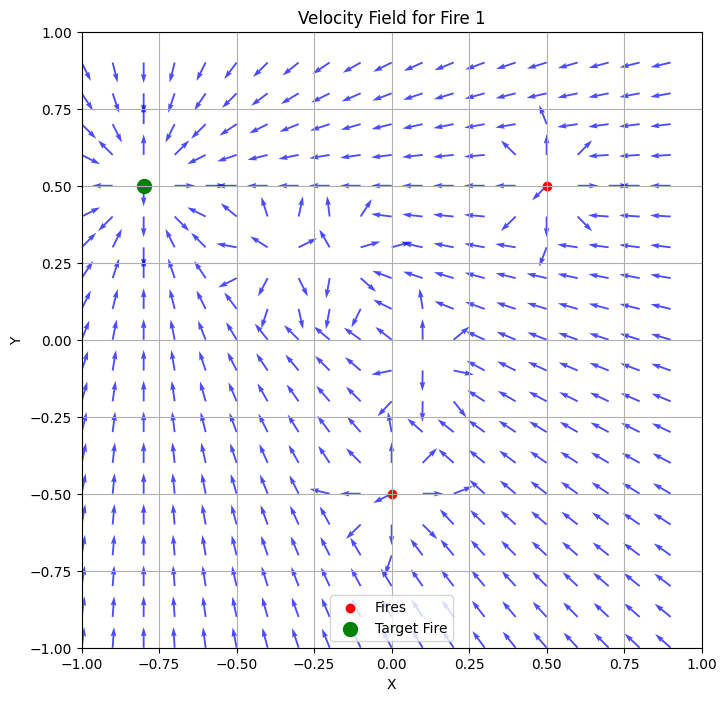

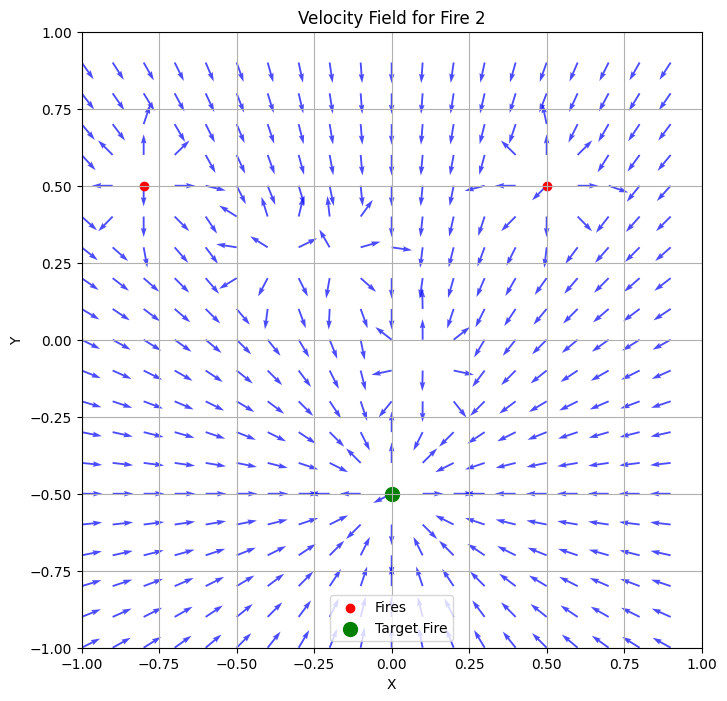

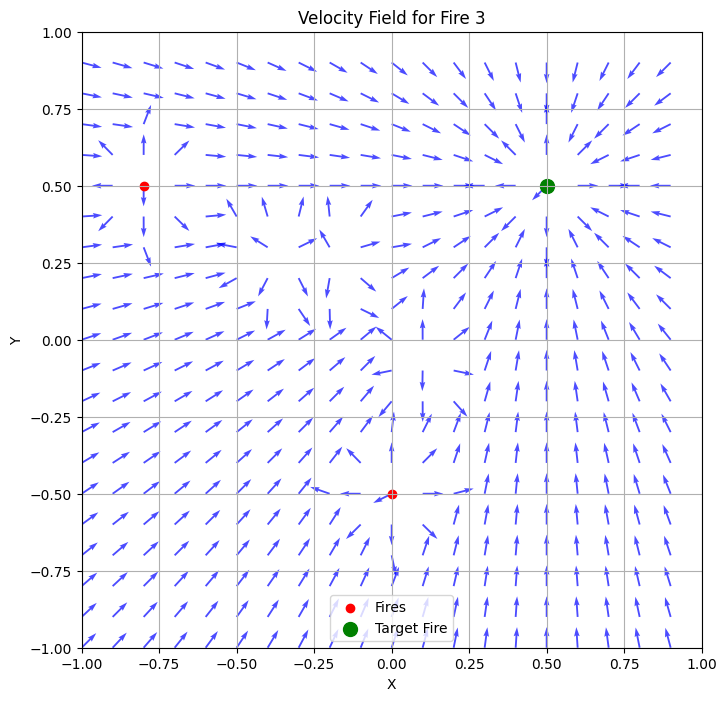

In [11]:
# Visualize velocity vectors on the grid for every fire_index
grid_resolution = 0.1
x_grid = np.arange(x_min, x_max, grid_resolution)
y_grid = np.arange(y_min, y_max, grid_resolution)
x_mesh, y_mesh = np.meshgrid(x_grid, y_grid)

for current_fire_index in range(len(fires)):
    u = np.zeros_like(x_mesh)
    v = np.zeros_like(y_mesh)

    for i in range(x_mesh.shape[0]):
        for j in range(x_mesh.shape[1]):
            position = np.array([x_mesh[i, j], y_mesh[i, j]])
            # Attractive force toward the current fire
            f_att = attractive_force(position, fires[current_fire_index].flatten())
            
            # Repulsive force from other fires (excluding current target fire)
            other_fires = [fire for k, fire in enumerate(fires) if k != current_fire_index and fire_status[k] > fire_threshold]
            concatenated_obstacles = np.hstack([tree_positions, *fires]) if fires else tree_positions
            # concatenated_fires = np.hstack(other_fires) if other_fires else np.empty((2, 0))
            f_rep = repulsive_force(position, concatenated_obstacles, fires, sensing_radius)
            
            # Combine forces
            f_total = f_att + f_rep
            u[i, j] = f_total[0]
            v[i, j] = f_total[1]

    # Normalize velocity vectors for better visualization
    magnitude = np.sqrt(u**2 + v**2)
    u = np.divide(u, magnitude, out=np.zeros_like(u), where=magnitude > 0)
    v = np.divide(v, magnitude, out=np.zeros_like(v), where=magnitude > 0)

    # Plot the velocity vectors using quiver
    plt.figure(figsize=(8, 8))
    plt.quiver(x_mesh, y_mesh, u, v, scale=30, color='blue', alpha=0.7)
    plt.scatter([fire[0, 0] for fire in fires], [fire[1, 0] for fire in fires], color='red', label='Fires')
    plt.scatter(fires[current_fire_index][0, 0], fires[current_fire_index][1, 0], color='green', label='Target Fire', s=100)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title(f'Velocity Field for Fire {current_fire_index + 1}')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(True)
    plt.show()


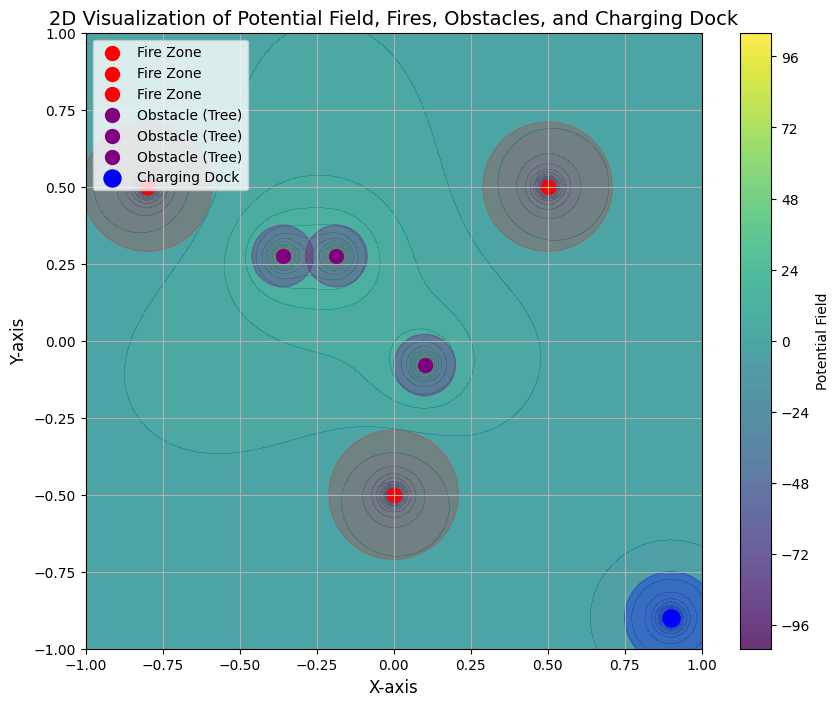

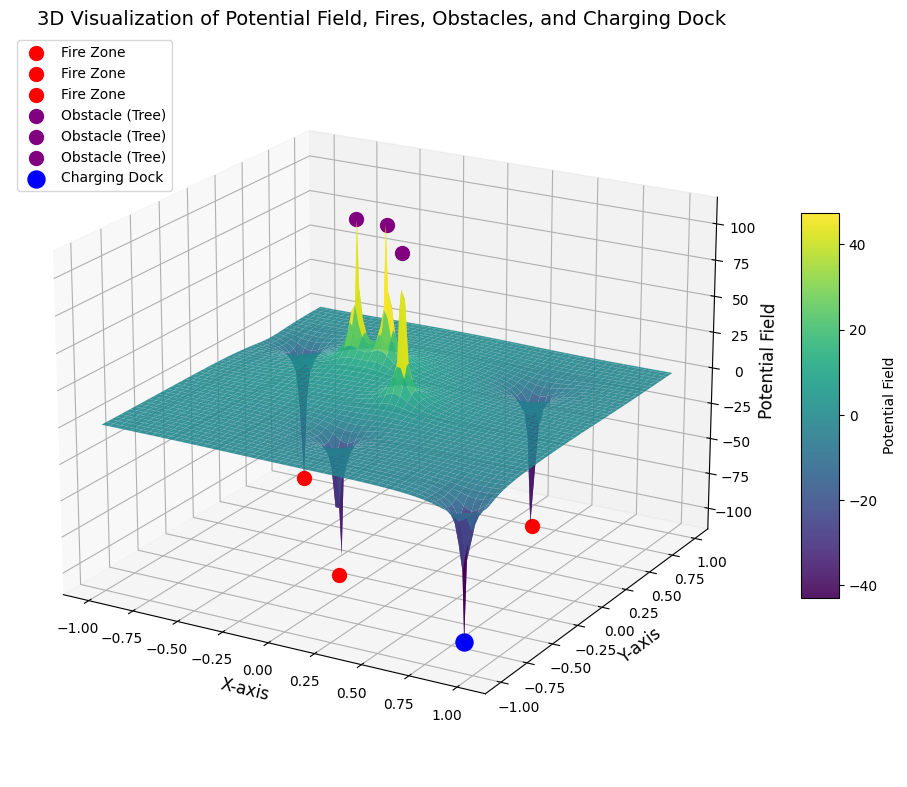

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from mpl_toolkits.mplot3d import Axes3D

# Parameters
x_min, x_max, y_min, y_max = -1, 1, -1, 1  # Grid limits
resolution = 100  # Resolution of the grid
k_uniform = 1.0  # Uniform potential scaling factor
fire_radius = 0.21  # Radius of the fire zone
obstacle_radius = 0.1  # Radius of obstacles
charging_radius = 0.15  # Radius of the charging dock
random_seed = 42  # Seed for reproducibility

# Fire zone locations
fires = [np.array([-0.8, 0.5]), np.array([0.0, -0.5]), np.array([0.5, 0.5])]

# Random obstacle (tree) locations
np.random.seed(random_seed)
num_trees = 3
tree_positions = np.random.uniform(0.4, -0.4, (2, num_trees))

# Charging station
charging_station = np.array([0.9, -0.9])

# Create grid for the potential field
x = np.linspace(x_min, x_max, resolution)
y = np.linspace(y_min, y_max, resolution)
x_mesh, y_mesh = np.meshgrid(x, y)

# Compute the potential field
potential_field = np.zeros_like(x_mesh)

# Add attractive potential (towards the fire zones)
for fire in fires:
    distance = np.sqrt((x_mesh - fire[0])**2 + (y_mesh - fire[1])**2)
    distance = np.maximum(distance, 0.01)  # Avoid division by zero
    potential_field -= k_uniform / distance  # Attractive towards fire zones

# Add repulsive potential (away from obstacles)
for tree in tree_positions.T:
    distance = np.sqrt((x_mesh - tree[0])**2 + (y_mesh - tree[1])**2)
    distance = np.maximum(distance, 0.01)  # Avoid division by zero
    potential_field += k_uniform / distance  # Repulsive from obstacles

# Add attractive potential (towards charging dock)
charging_distance = np.sqrt((x_mesh - charging_station[0])**2 + (y_mesh - charging_station[1])**2)
charging_distance = np.maximum(charging_distance, 0.01)
potential_field -= k_uniform / charging_distance  # Attractive towards charging dock

# Plot 2D potential field with fires, obstacles, and charging dock
plt.figure(figsize=(10, 8))
contour = plt.contourf(x_mesh, y_mesh, potential_field, levels=50, cmap="viridis", alpha=0.8)
plt.colorbar(contour, label="Potential Field")

# Plot fires
for fire in fires:
    plt.scatter(*fire, color="red", s=100, label="Fire Zone")
    circle = Circle(fire, fire_radius, color="red", alpha=0.2)
    plt.gca().add_patch(circle)

# Plot obstacles
for tree in tree_positions.T:  # Transpose to iterate over (x, y) pairs
    plt.scatter(*tree, color="purple", s=100, label="Obstacle (Tree)")
    circle = Circle(tree, obstacle_radius, color="purple", alpha=0.3)
    plt.gca().add_patch(circle)

# Plot charging station
plt.scatter(*charging_station, color="blue", s=150, label="Charging Dock")
circle = Circle(charging_station, charging_radius, color="blue", alpha=0.3)
plt.gca().add_patch(circle)

# Configure plot
plt.title("2D Visualization of Potential Field, Fires, Obstacles, and Charging Dock", fontsize=14)
plt.xlabel("X-axis", fontsize=12)
plt.ylabel("Y-axis", fontsize=12)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend(loc="upper left", fontsize=10)
plt.grid(True)
plt.gca().set_aspect("equal", adjustable="box")
plt.show()

# 3D Plot with Correct Visualization
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the potential field as a surface
surf = ax.plot_surface(
    x_mesh, y_mesh, potential_field,
    cmap='viridis',
    edgecolor='none',
    alpha=0.9
)

# Add a color bar to indicate potential field values
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label="Potential Field")

# Add fires as red scatter points in 3D
for fire in fires:
    ax.scatter(
        fire[0], fire[1], np.min(potential_field),  # Fire should be at the bottom (min potential)
        color="red", s=100, label="Fire Zone"
    )

# Add obstacles as purple scatter points in 3D
for tree in tree_positions.T:
    ax.scatter(
        tree[0], tree[1], np.max(potential_field),  # Obstacles should be at the top (max potential)
        color="purple", s=100, label="Obstacle (Tree)"
    )

# Add charging station as a blue dot at the goal
ax.scatter(
    charging_station[0], charging_station[1], np.min(potential_field),  # Charging dock at min potential
    color="blue", s=150, label="Charging Dock"
)

# Configure 3D plot
ax.set_title("3D Visualization of Potential Field, Fires, Obstacles, and Charging Dock", fontsize=14)
ax.set_xlabel("X-axis", fontsize=12)
ax.set_ylabel("Y-axis", fontsize=12)
ax.set_zlabel("Potential Field", fontsize=12)
ax.view_init(20, -60)  # Adjust the view angle
plt.legend(loc="upper left", fontsize=10)
plt.show()


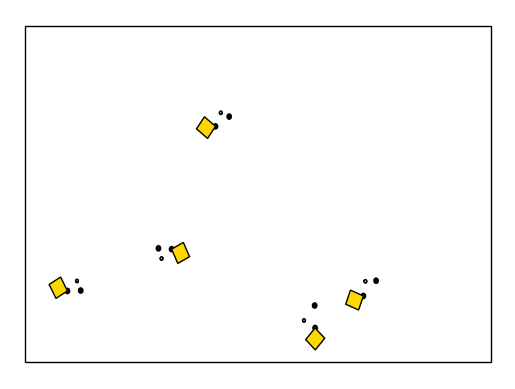

##### DEBUG OUTPUT #####
Your simulation will take approximately 81 real seconds when deployed on the Robotarium. 

No errors in your simulation! Acceptance of your experiment is likely!


<Figure size 640x480 with 0 Axes>

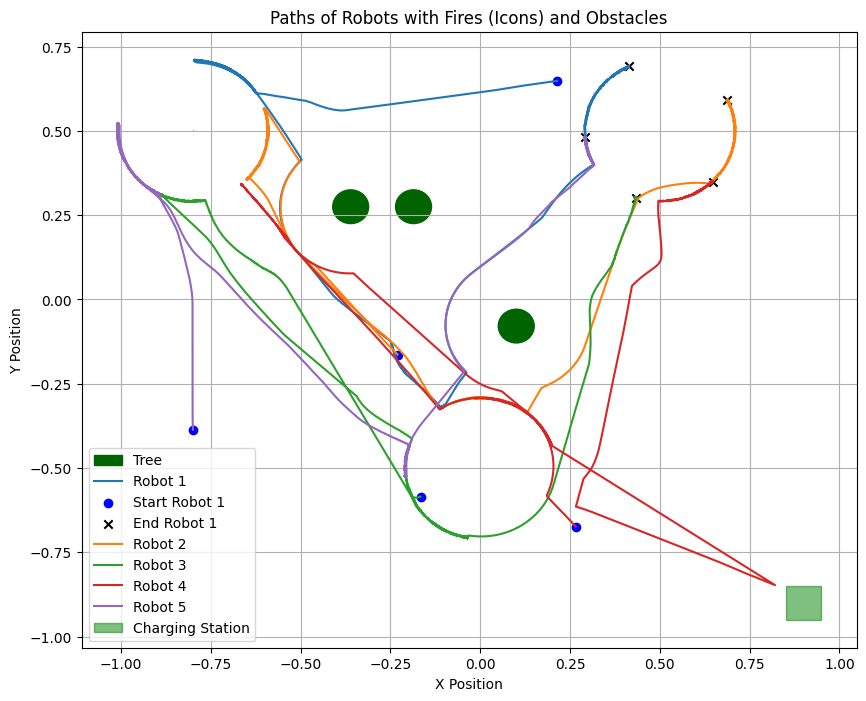

Plot saved as robot_paths.png in the current working directory.


In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rps.robotarium as robotarium
from rps.utilities.transformations import create_si_to_uni_mapping
from rps.utilities.barrier_certificates import create_single_integrator_barrier_certificate
from rps.utilities.controllers import create_si_position_controller
from matplotlib.patches import Circle
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Parameters
N = 5  # Number of robots
iterations = 4000  # Simulation iterations
sensing_radius = 0.2  # Sensing radius for obstacle avoidance
max_velocity = 0.1  # Maximum velocity to avoid actuator limit errors
fire_radius = 0.21  # Radius of the fire zone
fire_reduction_rate = 0.001  # Rate at which fire is reduced
fire_threshold = 0.01  # Threshold to consider fire extinguished
k_att = 1.0  # Attractive potential scaling factor
k_rep = 0.3  # Repulsive potential scaling factor
random_seed = 42  # Set a random seed for reproducibility

# Battery-related parameters
battery_levels = np.array([95, 90, 95, 55, 85], dtype=float)  # Initial battery percentages
battery_decay_rate = 0.025  # Battery reduction rate per step
low_battery_threshold = 25  # Threshold below which robots go to charging station
charging_station = np.array([0.9, -0.9])  # Bottom-right corner for charging station
charging_radius = 0.1  # Radius of the charging station

# Set random seed for reproducibility
np.random.seed(random_seed)

# Random obstacles (trees)
num_trees = 3  # Number of random obstacles
tree_positions = np.random.uniform(0.4, -0.4, (2, num_trees))  # Random positions for trees

# Create Robotarium instance
r = robotarium.Robotarium(number_of_robots=N, show_figure=True)

# Set up directory for saving frames
frame_dir = "D:/ASU/SEM3/MAE-598/final_project/frames"  # specify your frame directory here
os.makedirs(frame_dir, exist_ok=True)

# Initialize frame counter
frame_counter = 0

# Initialize robots at random positions within a bounded region
x_min, x_max = -1, 1  # Bounds for x-coordinate
y_min, y_max = -1, 1  # Bounds for y-coordinate

# Generate random positions for robots
initial_positions_x = np.random.uniform(x_min, x_max, size=N)  # Random x-coordinates
initial_positions_y = np.random.uniform(y_min, y_max, size=N)  # Random y-coordinates
initial_positions = np.vstack((initial_positions_x, initial_positions_y))  # Combine x and y

# Create transformations and controller
si_to_uni_dyn, uni_to_si_states = create_si_to_uni_mapping()
si_barrier_certificate = create_single_integrator_barrier_certificate()
si_position_controller = create_si_position_controller()

# Predefined fire locations
fires = [np.array([[-0.8], [0.5]]),  # Fire 1
         np.array([[0.0], [-0.5]]),  # Fire 2
         np.array([[0.5], [0.5]])]   # Fire 3

fire_status = [1.0, 1.0, 1.0]  # Fire intensity (1.0 = full intensity)

robot_paths = [[] for _ in range(N)]


# Add fire emoji as markers
fire_images = []
for fire in fires:
    fire_image = OffsetImage(plt.imread("fire.png"), zoom=0.07)  # Adjust initial zoom
    fire_box = AnnotationBbox(fire_image, fire.flatten(), frameon=False)
    r.axes.add_artist(fire_box)
    fire_images.append(fire_box)

# Draw a green square for the charging station
charging_square = plt.Rectangle((charging_station[0] - 0.05, charging_station[1] - 0.05),
                                 0.1, 0.1, color='green', alpha=0.5)
r.axes.add_patch(charging_square)

# Draw tree obstacles as small dark green circles
tree_circles = []
for i in range(num_trees):
    tree_circle = Circle(tree_positions[:, i], 0.05, color='darkgreen')
    r.axes.add_patch(tree_circle)
    tree_circles.append(tree_circle)

# Initialize a list to store battery annotations
battery_annotations = []
for i in range(N):
    annotation = r.axes.text(
        initial_positions[0, i], 
        initial_positions[1, i], 
        f"{battery_levels[i]:.0f}%", 
        fontsize=10, 
        color='blue'
    )
    battery_annotations.append(annotation)

# Move robots to their random initial positions
for _ in range(150):  # Run for a few iterations to move to initial positions
    poses = r.get_poses()
    si_states = uni_to_si_states(poses)
    velocities = si_position_controller(si_states, initial_positions)
    velocities = si_barrier_certificate(velocities, si_states)
    # Normalize velocities
    norms = np.linalg.norm(velocities, axis=0)
    mask = norms > max_velocity
    velocities[:, mask] = velocities[:, mask] / norms[mask] * max_velocity
    velocities = si_barrier_certificate(velocities, si_states)
    uni_velocities = si_to_uni_dyn(velocities, poses)
    r.set_velocities(np.arange(N), uni_velocities)
    r.step()

# Function to compute attractive potential gradient
def attractive_force(position, goal):
    return -k_att * (position - goal)

# Function to compute repulsive potential gradient
def repulsive_force(position, obstacles, fire_zones, sensing_radius):
    force = np.zeros_like(position)
    for obstacle in obstacles.T:
        diff = position - obstacle
        distance = np.linalg.norm(diff)
        if distance < sensing_radius:
            force += k_rep * (1/distance - 1/sensing_radius) * (1/distance**2) * (diff / distance)
    for fire_zone in fire_zones:
        diff = position - fire_zone.flatten()
        distance = np.linalg.norm(diff)
        if distance < fire_radius:
            force += k_rep * (1/distance - 1/fire_radius) * (1/distance**2) * (diff / distance)
    return force

# Function to check if robots are within the target distance of the fire
def within_fire_zone(positions, fire_location):
    distances = np.linalg.norm(positions - fire_location, axis=0)
    return distances <= fire_radius

# Main loop for robot motion
fire_index = 0
for _ in range(iterations):
    poses = r.get_poses()
    si_states = uni_to_si_states(poses)
    velocities = np.zeros_like(si_states)

    for i in range(N):
        robot_paths[i].append(si_states[:, i].copy())
    
    for i in range(si_states.shape[1]):
        if battery_levels[i] < low_battery_threshold:
            # Robot moves to the charging station
            f_att = attractive_force(si_states[:, i], charging_station)
            concatenated_obstacles = np.hstack([tree_positions, *fires]) if fires else tree_positions
            f_rep = repulsive_force(si_states[:, i], concatenated_obstacles, fires, sensing_radius)
            velocities[:, i] = f_att + f_rep
        else:
            # Normal behavior toward fire
            target_fire = fires[fire_index]
            f_att = attractive_force(si_states[:, i], target_fire.flatten())
            concatenated_obstacles = np.hstack([tree_positions, *fires]) if fires else tree_positions
            f_rep = repulsive_force(si_states[:, i], concatenated_obstacles, fires, sensing_radius)
            velocities[:, i] = f_att + f_rep
    
    # Normalize velocities
    norms = np.linalg.norm(velocities, axis=0)
    mask = norms > max_velocity
    velocities[:, mask] = velocities[:, mask] / norms[mask] * max_velocity
    velocities = si_barrier_certificate(velocities, si_states)
    uni_velocities = si_to_uni_dyn(velocities, poses)
    r.set_velocities(np.arange(N), uni_velocities)
    r.step()
    
    # Update battery levels
    battery_levels -= battery_decay_rate
    battery_levels = np.clip(battery_levels, 0, 100)
    
    # Update battery annotations
    for i, annotation in enumerate(battery_annotations):
        annotation.set_position((si_states[0, i], si_states[1, i]))
        annotation.set_text(f"{battery_levels[i]:.0f}%")
    
    # Handle fire extinguishing
    in_zone = within_fire_zone(si_states, fires[fire_index])
    if np.any(in_zone) and np.all(battery_levels >= low_battery_threshold):  # Only active robots extinguish fire
        fire_status[fire_index] -= fire_reduction_rate * np.sum(in_zone)
        fire_status[fire_index] = max(fire_status[fire_index], 0.0)
    if fire_status[fire_index] <= fire_threshold:
        fire_images[fire_index].remove()
        fire_index += 1
        if fire_index >= len(fires):
            break
    
    # Capture the frame
    plt.savefig(os.path.join(frame_dir, f"frame_{frame_counter:04d}.png"))
    frame_counter += 1

    # Update charging robots and check if they have reached the charging station
    for i in range(N):
        if battery_levels[i] < low_battery_threshold:
            distance_to_charging = np.linalg.norm(si_states[:, i] - charging_station)
            if distance_to_charging <= charging_radius:
                battery_levels[i] = 100  # Fully recharge battery
    
    # Update fire visualization: resize or hide fire emoji
    if fire_status[fire_index] <= fire_threshold:
        fire_images[fire_index].remove()  # Remove the marker when fire is extinguished
        fire_index += 1
        if fire_index >= len(fires):
            break  # All fires extinguished
    else:
        # Remove and replace the fire marker with updated zoom
        fire_images[fire_index].remove()
        fire_image = OffsetImage(plt.imread("fire.png"), zoom=fire_status[fire_index] * 0.07)
        fire_box = AnnotationBbox(fire_image, fires[fire_index].flatten(), frameon=False)
        r.axes.add_artist(fire_box)
        fire_images[fire_index] = fire_box


# End the simulation
r.call_at_scripts_end()

# Create the video from saved frames
# create_video(frame_dir, "simulation_output.mp4")

# Plot paths with obstacles, fires, and charging station
plt.figure(figsize=(10, 8))

# Plot obstacles (trees)
for i in range(num_trees):
    plt.gca().add_patch(Circle(tree_positions[:, i], radius=0.05, color='darkgreen', label='Tree' if i == 0 else None))

# Plot paths for all robots
for i, path in enumerate(robot_paths):
    path = np.array(path)  # Convert list of positions to numpy array
    plt.plot(path[:, 0], path[:, 1], label=f"Robot {i + 1}")
    plt.scatter(path[0, 0], path[0, 1], marker='o', color='blue', label=f"Start Robot {i + 1}" if i == 0 else None)
    plt.scatter(path[-1, 0], path[-1, 1], marker='x', color='black', label=f"End Robot {i + 1}" if i == 0 else None)

# Add charging station
plt.gca().add_patch(plt.Rectangle((charging_station[0] - 0.05, charging_station[1] - 0.05), 
                                   0.1, 0.1, color='green', alpha=0.5, label='Charging Station'))

# Add fire icons
for i, fire in enumerate(fires):
    fire_image = OffsetImage(plt.imread("fire.png"), zoom=fire_status[i] * 0.07)  # Adjust zoom based on fire intensity
    fire_box = AnnotationBbox(fire_image, fire.flatten(), frameon=False)
    plt.gca().add_artist(fire_box)

# Configure the plot
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Paths of Robots with Fires (Icons) and Obstacles")
plt.legend()
plt.grid()

# Save and show the plot
output_filename = "robot_paths.png"
plt.savefig(output_filename, dpi=300)  # Save the plot as an image
plt.show()

print(f"Plot saved as {output_filename} in the current working directory.")